# A Survey on Attention Mechanisms

### References

```
@misc{minimax2025minimax01scalingfoundationmodels,
      title={MiniMax-01: Scaling Foundation Models with Lightning Attention},
      author={MiniMax and Aonian Li and Bangwei Gong and Bo Yang and Boji Shan and Chang Liu and Cheng Zhu and Chunhao Zhang and Congchao Guo and Da Chen and Dong Li and Enwei Jiao and Gengxin Li and Guojun Zhang and Haohai Sun and Houze Dong and Jiadai Zhu and Jiaqi Zhuang and Jiayuan Song and Jin Zhu and Jingtao Han and Jingyang Li and Junbin Xie and Junhao Xu and Junjie Yan and Kaishun Zhang and Kecheng Xiao and Kexi Kang and Le Han and Leyang Wang and Lianfei Yu and Liheng Feng and Lin Zheng and Linbo Chai and Long Xing and Meizhi Ju and Mingyuan Chi and Mozhi Zhang and Peikai Huang and Pengcheng Niu and Pengfei Li and Pengyu Zhao and Qi Yang and Qidi Xu and Qiexiang Wang and Qin Wang and Qiuhui Li and Ruitao Leng and Shengmin Shi and Shuqi Yu and Sichen Li and Songquan Zhu and Tao Huang and Tianrun Liang and Weigao Sun and Weixuan Sun and Weiyu Cheng and Wenkai Li and Xiangjun Song and Xiao Su and Xiaodong Han and Xinjie Zhang and Xinzhu Hou and Xu Min and Xun Zou and Xuyang Shen and Yan Gong and Yingjie Zhu and Yipeng Zhou and Yiran Zhong and Yongyi Hu and Yuanxiang Fan and Yue Yu and Yufeng Yang and Yuhao Li and Yunan Huang and Yunji Li and Yunpeng Huang and Yunzhi Xu and Yuxin Mao and Zehan Li and Zekang Li and Zewei Tao and Zewen Ying and Zhaoyang Cong and Zhen Qin and Zhenhua Fan and Zhihang Yu and Zhuo Jiang and Zijia Wu},
      year={2025},
      eprint={2501.08313},
      archivePrefix={arXiv},
      primaryClass={cs.CL},
      url={https://arxiv.org/abs/2501.08313},
}`=
```

```
@article{liu2024deepseek,
  title={Deepseek-v2: A strong, economical, and efficient mixture-of-experts language model},
  author={Liu, Aixin and Feng, Bei and Wang, Bin and Wang, Bingxuan and Liu, Bo and Zhao, Chenggang and Dengr, Chengqi and Ruan, Chong and Dai, Damai and Guo, Daya and others},
  journal={arXiv preprint arXiv:2405.04434},
  year={2024}
}
```

```
@article{ainslie2023gqa,
  title={Gqa: Training generalized multi-query transformer models from multi-head checkpoints},
  author={Ainslie, Joshua and Lee-Thorp, James and De Jong, Michiel and Zemlyanskiy, Yury and Lebr{\'o}n, Federico and Sanghai, Sumit},
  journal={arXiv preprint arXiv:2305.13245},
  year={2023}
}
```

```
@article{shazeer2019fast,
  title={Fast transformer decoding: One write-head is all you need},
  author={Shazeer, Noam},
  journal={arXiv preprint arXiv:1911.02150},
  year={2019}
}
```

### Code

In [ ]:
!pip install jaxtyping treescope

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
import treescope
treescope.basic_interactive_setup(autovisualize_arrays=True)

In [1]:
from flax import linen as nn
from dataclasses import dataclass
import jax
import jax.numpy as jnp
import jax.sharding as shd
from jaxtyping import Float, Int, Bool, Array
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import matplotlib.pyplot as plt
import numpy as np

### Configurations

In [ ]:
@dataclass
class MiniMaxConfig:
    # MoE
    ffw_hidden_size: int = 9216
    num_experts: int = 32
    top_k: int = 2  # top-2 routing on MoE
    aux_loss_coef: float = 0.01

    # Attn
    num_heads: int = 64
    head_dim: int = 128
    group_size: int = 8  # for Group-Query Attention
    num_layers: int = 80
    linear_per_softmax: int = 7 # 7 transnormers, then 1 transformer
    hidden_size: int = 6144

    deepnorm_alpha: float = 0.81

    # RoPE
    rope_fraction: float = 0.5
    rope_base_freq: float = 10000

## Rotatory Positional Embeddings (RoPE)

We apply RoPE inside the attention mechanism:
$$(Q, K) \longrightarrow (\tilde{Q}, \tilde{K}) $$

RoPE applies a rotation to every 2D pair $(x_{2i}, x_{2i+1})$

$$
\begin{pmatrix}
x_{2i}^{\text{rot}} \\
x_{2i+1}^{\text{rot}}
\end{pmatrix}
=
\begin{pmatrix}
\cos(\theta_{p,i}) & -\sin(\theta_{p,i}) \\
\sin(\theta_{p,i}) & \cos(\theta_{p,i})
\end{pmatrix}
\begin{pmatrix}
x_{2i} \\[6pt]
x_{2i+1}
\end{pmatrix},
$$

$$\theta_i
\;=\; \frac{1}{\bigl(\text{rope_base_freq}\bigr)^{\,\frac{2\,i}{\text{rot_dim}}}}
\quad \text{for} \; i=0,\dots,\frac{\text{rot_dim}}{2}-1.$$

$$
p \;\in\; \{0, 1, 2, \dots, \text{seq_len}-1\}.
$$

$$\alpha_{p,i} \;=\; p \cdot \theta_i.$$

$$
\sin_{p,i} \;=\; \sin(\alpha_{p,i}),
\quad
\cos_{p,i} \;=\; \cos(\alpha_{p,i}).
$$

Usage:
```
class YourClass(nn.Module):
    config: MiniMaxConfig

    def setup(self):
        self.rope = RotatoryPositionEmbedding(config=config)

    def __call__(self, *args):
        q_rot, k_rot = self.rope(q, k)
```

In [ ]:
class RotaryPositionEmbedding(nn.Module):
    """
    A Flax module that applies partial Rotary Position Embeddings (RoPE) to
    query and key tensors. By default, only a fraction of each head dimension
    (specified by `rope_fraction`) is rotated, and the remaining dimensions
    remain unaltered.

    Attributes:
        config (MiniMaxConfig): A configuration object specifying RoPE fraction
            and base frequency.
    """
    config: MiniMaxConfig

    def _get_rotary_matrix(
        self,
        seq_len: int,
        rot_dim: int
    ) -> Tuple[Float[Array, "seq rot_dim//2"], Float[Array, "seq rot_dim//2"]]:
        """
        Generate the sine and cosine matrices for the rotary transformations.

        Args:
            seq_len (int): Length of the sequence (number of positions).
            rot_dim (int): Number of head-dimension channels to which
                           RoPE is applied.

        Returns:
            sin (Float[Array, "seq rot_dim//2"]):
                The sine values, shape = [seq_len, rot_dim//2].
            cos (Float[Array, "seq rot_dim//2"]):
                The cosine values, shape = [seq_len, rot_dim//2].
        """
        theta = 1.0 / (self.config.rope_base_freq **
                      (2 * jnp.arange(0, rot_dim // 2) / rot_dim))
        positions = jnp.arange(seq_len, dtype=jnp.float32)
        angles = positions[:, None] * theta[None, :]
        return jnp.sin(angles), jnp.cos(angles)

    @nn.compact
    def __call__(
        self,
        q: Float[Array, "batch seq_len num_heads head_dim"],
        k: Float[Array, "batch seq_len num_heads head_dim"]
    ) -> Tuple[
        Float[Array, "batch seq_len num_heads head_dim"],
        Float[Array, "batch seq_len num_heads head_dim"]
    ]:
        """
        Applies rotary position embeddings to the first `rot_dim` channels
        of query (q) and key (k) tensors. The remaining channels of each head
        dimension are left unrotated.

        Args:
            q (Float[Array, "batch seq_len num_heads head_dim"]):
                The query tensor.
            k (Float[Array, "batch seq_len num_heads head_dim"]):
                The key tensor.

        Returns:
            A tuple (q_rot, k_rot) where:
            - q_rot (Float[Array, "batch seq_len num_heads head_dim"]):
                The query tensor after applying partial RoPE.
            - k_rot (Float[Array, "batch seq_len num_heads head_dim"]):
                The key tensor after applying partial RoPE.
        """
        batch_size, seq_len, num_heads, head_dim = q.shape
        rot_dim = int(self.config.rope_fraction * head_dim)

        # Generate sine and cosine for the rotary transformation
        sin, cos = self._get_rotary_matrix(seq_len, rot_dim)

        # Reshape for broadcasting:
        # sin, cos -> [1, seq, 1, rot_dim//2, 1]
        sin = sin[None, :, None, :]
        cos = cos[None, :, None, :]

        def rotate_tensor(x: Float[Array, "batch seq_len num_heads head_dim"]
                          ) -> Float[Array, "batch seq_len num_heads head_dim"]:
            """
            Rotate the first `rot_dim` channels of x with the RoPE transformation.
            """
            x_rot = x[..., :rot_dim].reshape(*x.shape[:-1], rot_dim // 2, 2)
            x_rot = jnp.stack([
                x_rot[..., 0] * cos - x_rot[..., 1] * sin,
                x_rot[..., 0] * sin + x_rot[..., 1] * cos
            ], axis=-1)

            return jnp.concatenate([
                x_rot.reshape(*x.shape[:-1], rot_dim),
                x[..., rot_dim:]
            ], axis=-1)

        return rotate_tensor(q), rotate_tensor(k)

### Testing RoPE on Key-Query Pairs

In [ ]:
config = MiniMaxConfig(
    # Rotate a fraction of dimensions (set <1.0 for partial rotation)
    rope_fraction=0.5,
    rope_base_freq=10000.0
)

rope_module = RotaryPositionEmbedding(config=config)

batch_size = 1
seq_length = 50
num_heads = 4
head_dim = 128

In [ ]:
# Random queries and keys for demonstration
q = jnp.ones((batch_size, seq_length, num_heads, head_dim))
k = jnp.ones((batch_size, seq_length, num_heads, head_dim))

variables = rope_module.init(jax.random.PRNGKey(0), q, k)

In [ ]:
q_rot, k_rot = rope_module.apply(variables, q, k)

# Visualization of the rotated query tensor
# Taking the first head from the first batch for visualization
q_rot_np = np.array(q_rot[0, :, 0, :])

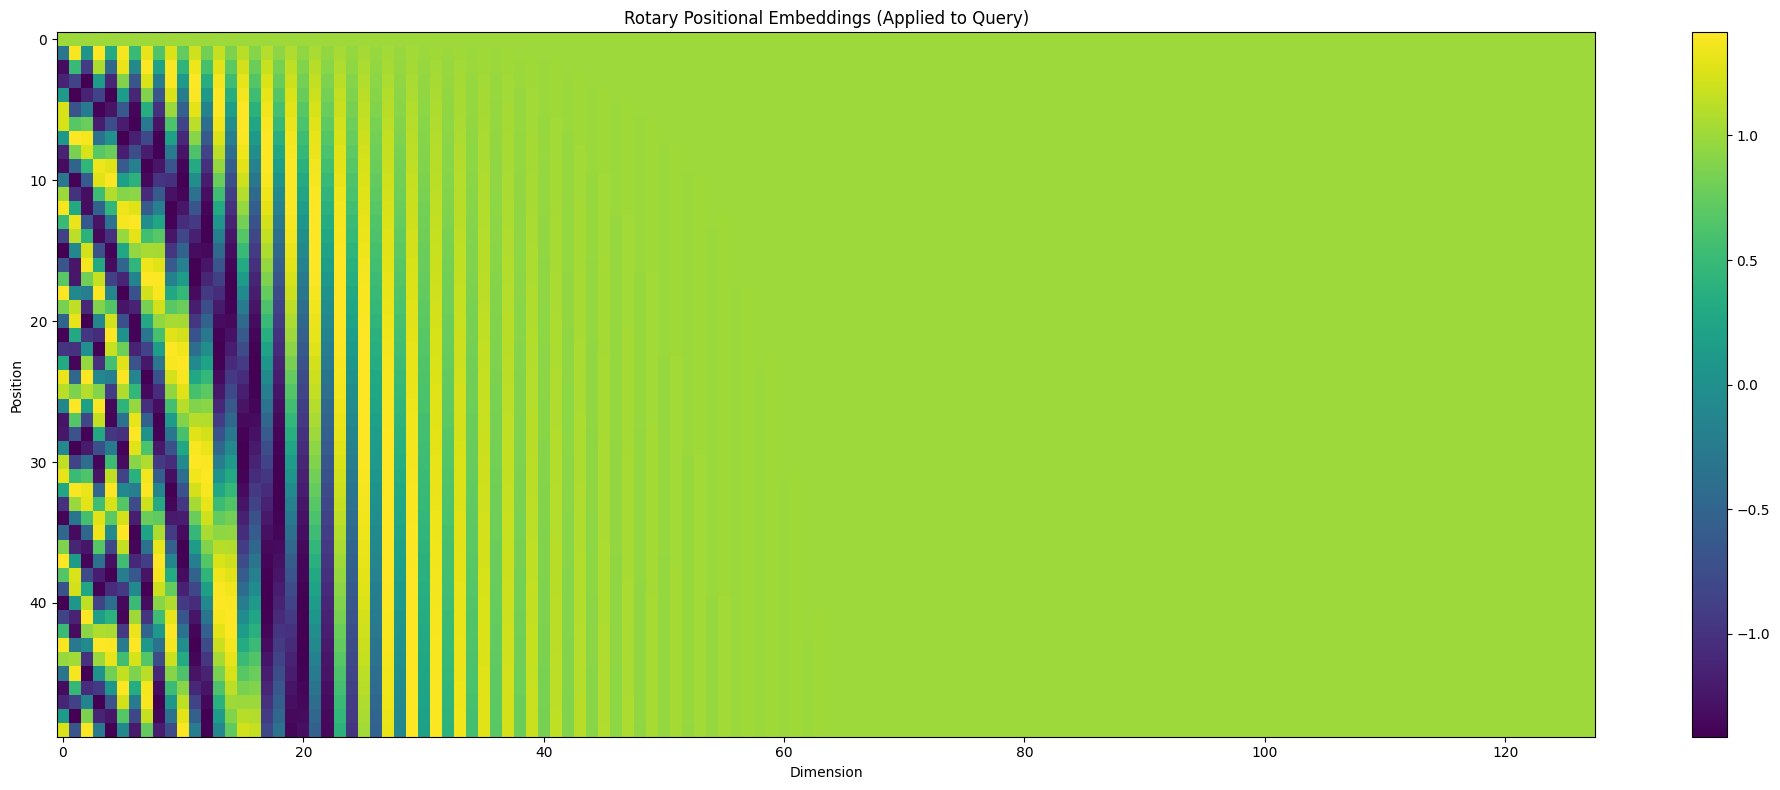

In [ ]:
plt.figure(figsize=(20, 8))
plt.imshow(q_rot_np, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Rotary Positional Embeddings (Applied to Query)')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.tight_layout()
plt.show()

### Initialization Strategies

In [ ]:
xavier_uniform = nn.initializers.variance_scaling(
    scale=1.0,
    mode='fan_avg',
    distribution='uniform'
)

## RMS Norm

$$
\text{RMSNorm}(x) = g \odot \frac{x}{\sqrt{\frac{1}{d} \sum_{i=1}^{d} x_i^2 + \epsilon}}
$$

In [ ]:
class RMSNorm(nn.Module):
    """
    Implements Root Mean Square Layer Normalization (RMSNorm) using Flax.

    RMSNorm normalizes the input across the last dimension based on the
    root mean square of the values in that dimension.

    Attributes:
        epsilon (float): A small constant added for numerical stability to
            avoid division by zero.
    """
    epsilon: float = 1e-6

    @nn.compact
    def __call__(
        self,
        x: Float[Array, "batch seq_len hidden_size"],
    ) -> Float[Array, "batch seq_len hidden_size"]:
        """
        Forward pass of the RMSNorm layer.

        This normalizes the input tensor along its last dimension, then
        optionally scales it by a learned parameter vector.

        Args:
            x (Float[Array, "batch seq_len hidden_size"]):
                The input tensor of shape (batch, seq_len, hidden_size).

        Returns:
            Float[Array, "batch seq_len hidden_size"]:
                The normalized output tensor of the same shape as the input.
        """
        dtype = x.dtype

        # Convert input to float32 for numerical stability in norm calculations
        x = x.astype(jnp.float32)

        g = self.param(
            'scale',
            nn.initializers.ones,
            (x.shape[-1],)
        )

        rms = jnp.sqrt(
            jnp.mean(jnp.square(x), axis=-1, keepdims=True) + self.epsilon
        )

        x_norm = x / rms

        # Multiply by the learned scale, then cast back to the original dtype
        return (g * x_norm).astype(dtype)

# Softmax Attention

## Equations
##### Linear Projection
$$
Q = X W_Q + b_Q, \quad K = X W_K + b_K, \quad V = X W_V + b_V
$$
##### Reshaping
$$
Q \in \mathbb{R}^{(B, S, N_h, d_h)}, \quad K, V \in \mathbb{R}^{(B, S, N_{kv}, d_h)}
$$

##### Rotatory Positional Embeddings
$$
Q' = \text{RoPE}(Q), \quad K' = \text{RoPE}(K)
$$

##### Transpose for Attention Computation
$$
Q' \in \mathbb{R}^{(B, N_h, S, d_h)}, \quad K' \in \mathbb{R}^{(B, N_{kv}, S, d_h)}, \quad V \in \mathbb{R}^{(B, N_{kv}, S, d_h)}
$$

#####  Repeat K and V for Grouped Query Attention

$$
K'' = \text{repeat}(K', \text{group_size}, \text{axis}=1) \\ V'' = \text{repeat}(V, \text{group_size}, \text{axis}=1)
$$

##### Scaled Dot-Product Attention Score Computation
$$
A = \frac{Q' K''^T}{\sqrt{d_h}}
$$

##### Masking (if applied)

$$
\begin{array}{c} A'_{ij} =
\begin{cases}
A_{ij}, & \text{if mask}_{ij} = 1 \\
-10^9, & \text{if mask}_{ij} = 0
\end{cases} \end{array}
$$

##### Softmax Computation
$$
P = \text{softmax}(A', \text{axis}=-1)
$$

#####  Attention Output Computation
$$
O = P V''
O \in \mathbb{R}^{(B, N_h, S, d_h)}
$$


##### Reshape and Final Projection
$$
O' = \text{reshape}(\text{transpose}(O, (0, 2, 1, 3)), (B, S, N_h \cdot d_h))
Y = O' W_O + b_O
$$

where $W_O \in \mathbb{R}^{(N_h \cdot d_h, H)}$ projects back to the hidden size.

In [ ]:
class SoftmaxAttention(nn.Module):
    """
    Implements standard scaled dot-product attention with an optional
    Grouped Query Attention (GQA) mechanism using repeated keys and values.
    """
    config: MiniMaxConfig

    def setup(self):
        self.num_heads = self.config.num_heads
        self.head_dim = self.config.head_dim
        self.group_size = self.config.group_size   # => "kv heads"
        self.hidden_size = self.config.hidden_size

        # For GQA:
        # - Q is projected to 64 heads
        # - K, V are projected to only 8 heads, repeated at runtime.
        self.num_kv_heads = self.num_heads // self.group_size  # 64 // 8 = 8

        self.rope = RotaryPositionEmbedding(config=self.config)

        self.q_proj = nn.Dense(features=self.num_heads * self.head_dim,
                               kernel_init=xavier_uniform, name="q_proj")
        self.k_proj = nn.Dense(features=self.num_kv_heads * self.head_dim,
                               kernel_init=xavier_uniform, name="k_proj")
        self.v_proj = nn.Dense(features=self.num_kv_heads * self.head_dim,
                               kernel_init=xavier_uniform, name="v_proj")
        self.out_proj = nn.Dense(features=self.hidden_size,
                               kernel_init=xavier_uniform, name="out_proj")

    def __call__(self,
                 hidden_states: Float[Array, "batch seq_len hidden_size"],
                 mask: Optional[Float[Array, "batch 1 seq_len seq_len"]] = None
                ) -> Float[Array, "batch seq_len hidden_size"]:
        """
        Forward pass of the softmax attention mechanism.

        Args:
            hidden_states: A float Tensor of shape (batch, seq_len, hidden_size),
                where hidden_size can be num_heads * head_dim or similar.
            mask: An optional boolean or float mask of shape
                (batch, 1, seq_len, seq_len) indicating which positions
                are valid (True) or invalid (False). If True means keep,
                those entries are left as-is. If False, they are set
                to a large negative number before softmax.

        Returns:
            A float Tensor of shape (batch, seq_len, hidden_size)
            after applying the attention mechanism.
        """

        batch_size, seq_len, _ = hidden_states.shape

        q = self.q_proj(hidden_states)  # (b, s, 8192)
        k = self.k_proj(hidden_states)  # (b, s, 1024)
        v = self.v_proj(hidden_states)  # (b, s, 1024)

        # Q => (b, s, 64, 128), K => (b, s, 8, 128), V => (b, s, 8, 128)
        q = q.reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.reshape(batch_size, seq_len, self.num_kv_heads, self.head_dim)
        v = v.reshape(batch_size, seq_len, self.num_kv_heads, self.head_dim)

        q, k = self.rope(q, k)

        # Q => (b, 64, s, 128), K => (b, 8, s, 128), V => (b, 8, s, 128)
        q = jnp.transpose(q, (0, 2, 1, 3))
        k = jnp.transpose(k, (0, 2, 1, 3))
        v = jnp.transpose(v, (0, 2, 1, 3))

        # K, V => (b, 8, s, 128) => replicate 8 times => (b, 64, s, 128)
        k = jnp.repeat(k, self.group_size, axis=1)
        v = jnp.repeat(v, self.group_size, axis=1)

        # Scaled dot-product attention => attn_scores => shape (b, 64, s, s)
        attn_scores = jnp.einsum("bhqd,bhkd->bhqk", q, k)
        attn_scores = attn_scores / jnp.sqrt(self.head_dim)

        # (Optional) Apply causal or padding mask
        if mask is not None:
            # mask shape is (b, 1, s, s), broadcast to (b, 64, s, s)
            big_neg = jnp.array(-1e9, dtype=attn_scores.dtype)
            attn_scores = jnp.where(mask, attn_scores, big_neg)

        # Softmax over the last dimension (the "key" positions)
        attn_probs = nn.softmax(attn_scores, axis=-1)

        # Apply attention to values => (b, 64, s, 128)
        attn_output = jnp.einsum("bhqk,bhkd->bhqd", attn_probs, v)

        # Reshape back to (b, s, 64*128=8192) => then project to 6144
        attn_output = jnp.transpose(attn_output, (0, 2, 1, 3))
        attn_output = attn_output.reshape(batch_size, seq_len, -1)

        # Note, from the paper Sec. 2.0 ¶3, it's hard to understand the
        # "hidden size" == 6144. Usually it's num_heads * head_dim (8192 for us)
        # The assumption is that there is this down-projection at the end
        return self.out_proj(attn_output)

### Testing Softmax Attention

In [ ]:
config = MiniMaxConfig(
    num_heads=64,
    head_dim=128,
    group_size=8,
    hidden_size=6144,
    rope_fraction=0.5,
    rope_base_freq=10000.0
)

attention = SoftmaxAttention(config=config)

In [ ]:
rng = jax.random.PRNGKey(0)
batch, seq_len, hidden_size = 2, 10, 6144
dummy_inputs = jnp.ones((batch, seq_len, hidden_size))

mask = jnp.tril(jnp.ones((1, 1, seq_len, seq_len), dtype=bool))

# Initialize parameters
params = attention.init(rng, dummy_inputs, mask)
print("Parameter shapes:")
for k, v in params["params"].items():
    print(k, jax.tree.map(jnp.shape, v))

output = attention.apply(params, dummy_inputs, mask=mask)
print("Output shape:", output.shape)

Parameter shapes:
q_proj {'bias': (8192,), 'kernel': (6144, 8192)}
k_proj {'bias': (1024,), 'kernel': (6144, 1024)}
v_proj {'bias': (1024,), 'kernel': (6144, 1024)}
out_proj {'bias': (6144,), 'kernel': (8192, 6144)}
Output shape: (2, 10, 6144)


# Mixture Of Experts
$$
h_t = \sum_{i=1}^E\text{Softmax}_i(\text{TopK}(x_t\cdot W_g))\cdot FFN_i(x_t)
$$

TopK(·) denotes the operation that preserves the top 𝑘 scores among all 𝐸 experts while
setting the remaining scores to −∞.

In [ ]:
class ExpertMLP(nn.Module):
    """Implements individual expert FFN with hidden dimension expansion.

    Args:
        x: Input tensor of shape [batch, seq_len, hidden] or [tokens, hidden]

    Returns:
        Transformed tensor with same shape as input
    """
    config: MiniMaxConfig

    @nn.compact
    def __call__(self, x: Float[Array, "... hidden_dims"]) -> Float[Array, "... hidden_dims"]:
        # Expand to intermediate dimension
        x = nn.Dense(self.config.ffw_hidden_size,
                   kernel_init=xavier_uniform,
                   name="expert_expand")(x)
        x = nn.relu(x)
        return nn.Dense(self.config.hidden_size,
                      kernel_init=xavier_uniform,
                      name="expert_contract")(x)

#### Testing FFN

In [ ]:
rng = jax.random.PRNGKey(0)
dummy_input = jnp.ones((2, 5, 6144))
expert = ExpertMLP(MiniMaxConfig())
params = expert.init(rng, dummy_input)

expand_weights = params['params']['expert_expand']['kernel']
contract_weights = params['params']['expert_contract']['kernel']

print("\n=== FFN Test ===")
print(f"Expand layer weights - Mean: {jnp.mean(expand_weights):.4f}")
print(f"Expand layer weights - Std: {jnp.std(expand_weights):.4f}")
print(f"Contract layer weights - Mean: {jnp.mean(contract_weights):.4f}")
print(f"Contract layer weights - Std: {jnp.std(contract_weights):.4f}")



=== FFN Test ===
Expand layer weights - Mean: 0.0000
Expand layer weights - Std: 0.0114
Contract layer weights - Mean: 0.0000
Contract layer weights - Std: 0.0114


In [ ]:
class GlobalRouter(nn.Module):
    """Handles token-to-expert routing with top-k selection and load balancing.

    Args:
        x: Flattened input tensor of shape [tokens, hidden]

    Returns:
        Tuple of (expert indices, routing scores, expert mask, aux loss)
    """
    config: MiniMaxConfig

    @nn.compact
    def __call__(self, x: Float[Array, "tokens hidden"]
                ) -> Tuple[Int[Array, "tokens top_k"],
                           Float[Array, "tokens top_k"],
                           Bool[Array, "tokens top_k experts"],
                           Float[Array, ""]]:
        gate_logits = nn.Dense(self.config.num_experts,
                               kernel_init=xavier_uniform, name="router_gate")(x)

        # Top-k expert selection
        scores, expert_indices = jax.lax.top_k(gate_logits, self.config.top_k)
        scores = jax.nn.softmax(scores, axis=-1)

        # Create expert assignment mask
        expert_mask = jax.nn.one_hot(expert_indices, self.config.num_experts)

        f_i = jnp.mean(expert_mask, axis=(0, 1))
        m_i = jnp.mean(jax.nn.softmax(gate_logits, axis=-1), axis=0)  # Mean probs
        aux_loss = self.config.aux_loss_coef * jnp.sum(f_i * m_i) / self.config.num_experts

        return expert_indices, scores, expert_mask, aux_loss


#### Testing Global Router

In [ ]:
rng = jax.random.PRNGKey(0)
num_tokens = 10  # batch_size * seq_len
dummy_input = jax.random.normal(rng, (num_tokens, 6144))

router = GlobalRouter(MiniMaxConfig())
params = router.init(rng, dummy_input)
indices, scores, mask, loss = router.apply(params, dummy_input)

print("\n=== GlobalRouter Test ===")
print(f"Expert indices shape: {indices.shape}")
print(f"Routing scores shape: {scores.shape}")
print(f"Expert mask shape: {mask.shape}")
print(f"Aux loss value: {loss:.4f}")
print(f"Aux loss is scalar: {loss.ndim == 0}")


=== GlobalRouter Test ===
Expert indices shape: (10, 2)
Routing scores shape: (10, 2)
Expert mask shape: (10, 2, 32)
Aux loss value: 0.0000
Aux loss is scalar: True


In [ ]:
class MoEBlock(nn.Module):
    """MoE transformer block implementing token-drop strategy with capacity limits."""
    config: MiniMaxConfig

    def setup(self):
        self.router = GlobalRouter(self.config)
        self.experts = [ExpertMLP(self.config) for _ in range(self.config.num_experts)]

    def __call__(self, x: Float[Array, "batch seq_len hidden"]) -> Tuple[Float[Array, "batch seq_len hidden"], Float[Array, ""]]:
        batch_size, seq_len, _ = x.shape
        num_tokens = batch_size * seq_len
        x_flat = x.reshape(num_tokens, -1)  # [tokens, hidden]

        # Get routing decisions
        expert_indices, scores, expert_mask, aux_loss = self.router(x_flat)

        assert expert_indices.shape == (num_tokens, self.config.top_k), "Expert indices shape mismatch"
        assert scores.shape == (num_tokens, self.config.top_k), "Scores shape mismatch"
        assert expert_mask.shape == (num_tokens, self.config.top_k, self.config.num_experts), "Expert mask shape mismatch"

        output = jnp.zeros_like(x_flat)
        for expert_idx in range(self.config.num_experts):
            output += self._process_expert(
                x_flat,
                expert_idx,
                expert_mask[..., expert_idx],  # [tokens, top_k]
                scores,  # [tokens, top_k]
                num_tokens
            )

        return output.reshape(batch_size, seq_len, -1), aux_loss

    def _process_expert(
        self,
        x: Float[Array, "tokens hidden"],
        expert_idx: int,
        mask: Bool[Array, "tokens top_k"],
        scores: Float[Array, "tokens top_k"],
        num_tokens: int
    ) -> Float[Array, "tokens hidden"]:
        """Process tokens through a single expert with capacity constraints."""
        capacity = max((num_tokens * self.config.top_k) // self.config.num_experts, 1)

        # Select tokens and scores with validation
        tokens, scores_expert = self._select_tokens(x, scores, mask, capacity)
        assert tokens.shape[0] <= capacity, "Token selection exceeds capacity"
        assert scores_expert.shape == (capacity,), "Scores shape mismatch"

        # Process through expert
        expert_out = self.experts[expert_idx](tokens)
        assert expert_out.shape == (capacity, self.config.hidden_size), "Expert output shape mismatch"

        # Scatter outputs with dimension checks
        scattered = self._scatter_outputs(
            expert_out, scores_expert, mask, capacity, num_tokens
        )
        assert scattered.shape == (num_tokens, self.config.hidden_size), "Scattering shape mismatch"

        return scattered

    def _select_tokens(
        self,
        x: Float[Array, "tokens hidden"],
        scores: Float[Array, "tokens top_k"],
        mask: Bool[Array, "tokens top_k"],
        capacity: int
    ) -> Tuple[Float[Array, "capacity hidden"], Float[Array, "capacity"]]:
        """Select tokens for expert processing based on routing scores."""

        # Get raw indices [capacity, 2]
        token_indices = jnp.argwhere(mask, size=capacity, fill_value=-1)

        # Validate indices
        assert token_indices.shape == (capacity, 2), f"Indices shape {token_indices.shape} != ({capacity}, 2)"

        # Extract coordinates
        i_indices = token_indices[..., 0]  # [capacity]
        j_indices = token_indices[..., 1]  # [capacity]
        valid_mask = (i_indices != -1) & (j_indices != -1)

        # Get scores for selected positions
        scores_expert = scores[i_indices, j_indices] * valid_mask

        # Sort by scores (descending) with valid entries first
        sort_order = jnp.argsort(-scores_expert)

        return x[i_indices][sort_order], scores_expert[sort_order]

    def _scatter_outputs(
        self,
        expert_out: Float[Array, "capacity hidden"],
        scores: Float[Array, "capacity"],
        mask: Bool[Array, "tokens top_k"],
        capacity: int,
        num_tokens: int
    ) -> Float[Array, "tokens hidden"]:
        """Distribute expert outputs back to original token positions."""
        # Get token indices (i) from mask [capacity]
        token_indices = jnp.argwhere(mask, size=capacity, fill_value=-1)[..., 0]
        valid = token_indices != -1

        # Calculate weighted outputs
        weighted = expert_out * scores[:, None] * valid[:, None]

        # Validate scattering dimensions
        assert weighted.shape == (capacity, self.config.hidden_size), f"Weighted shape {weighted.shape} mismatch"
        assert token_indices.shape == (capacity,), f"Indices shape {token_indices.shape} mismatch"

        # Aggregate outputs
        return jax.ops.segment_sum(
            weighted,
            token_indices,
            num_segments=num_tokens
        )

### Testing MoE Block

In [ ]:
config = MiniMaxConfig(
    ffw_hidden_size=9216,
    num_experts=8,
    top_k=2,
    hidden_size=6144
)
batch_size = 4
seq_len = 512

In [ ]:
print("\n=== Creating MoE Block ===")
print(f"Config: {config}")
moe_block = MoEBlock(config)
print("MoE block created with:")
print(f"- {config.num_experts} experts")
print(f"- Top-{config.top_k} routing")
print(f"- Expert hidden size: {config.ffw_hidden_size}")



=== Creating MoE Block ===
Config: MiniMaxConfig(ffw_hidden_size=9216, num_experts=8, top_k=2, aux_loss_coef=0.01, num_heads=64, head_dim=128, group_size=8, num_layers=80, linear_per_softmax=7, hidden_size=6144, deepnorm_alpha=0.81, rope_fraction=0.5, rope_base_freq=10000)
MoE block created with:
- 8 experts
- Top-2 routing
- Expert hidden size: 9216


In [ ]:
rng = jax.random.PRNGKey(0)
dummy_input = jax.random.normal(rng, (batch_size, seq_len, config.hidden_size))
params = moe_block.init(rng, dummy_input)


In [ ]:
print("\n=== MoE Block Forward Pass ===")
# Generate test input with random values
test_input = jax.random.normal(rng, (batch_size, seq_len, config.hidden_size))
print(f"Input shape: {test_input.shape}")
print(f"Input stats - Mean: {jnp.mean(test_input):.4f}, Std: {jnp.std(test_input):.4f}")

# Run forward pass
output, aux_loss = moe_block.apply(params, test_input)

print("\n=== Output Verification ===")
print(f"Output shape: {output.shape}")
print(f"Output matches input shape: {output.shape == test_input.shape}")
print(f"Output stats - Mean: {jnp.mean(output):.4f}, Std: {jnp.std(output):.4f}")

print("\n=== Auxiliary Loss Check ===")
print(f"Aux loss value: {aux_loss:.4f}")
print(f"Aux loss is scalar: {aux_loss.ndim == 0}")

print("\n=== Sanity Checks ===")
# Verify non-zero output
print(f"Output is all zeros: {jnp.allclose(output, 0)}")

# Verify expert diversity
gate_params = params['params']['router']['router_gate']
print(f"Gate weights shape: {gate_params['kernel'].shape}")
print(f"Gate bias shape: {gate_params['bias'].shape}")


=== MoE Block Forward Pass ===
Input shape: (4, 512, 6144)
Input stats - Mean: -0.0008, Std: 0.9996

=== Output Verification ===
Output shape: (4, 512, 6144)
Output matches input shape: True
Output stats - Mean: 0.0022, Std: 0.5265

=== Auxiliary Loss Check ===
Aux loss value: 0.0002
Aux loss is scalar: True

=== Sanity Checks ===
Output is all zeros: False
Gate weights shape: (6144, 8)
Gate bias shape: (8,)


# Classical Transformer


## Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    config: MiniMaxConfig

    # in progress